# Variational Auto Encoder with TensorFlow

VAE trained on MNIST dataset. Both the encoder and decoder are fully-connected NNs.

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

Download and load the dataset

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


Preprocess the input. The images will be rescaled so all the pixels have a value between 0 and 1. This enables the decoder to learn a Bernoulli distribution over the pixel space.

In [4]:
def pre_process_imgs(img):
    img = tf.cast(img, tf.float32)
    img = img / 255.0
    return img

create the dataset object and batch the data

In [5]:
MNIST_dataset = tf.data.Dataset.from_tensor_slices(x_train)
MNIST_dataset = MNIST_dataset.map(pre_process_imgs).batch(128)

2022-10-17 17:34:48.183520: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Encoder
A simple NN with one hidden layer and two heads for mean and variance($log(\sigma^2)$) of the latent normal distributions. 

In [6]:
class MnistEncoder(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, latent_dim):
        super(MnistEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.dense_mu = tf.keras.layers.Dense(self.latent_dim, activation=None)
        self.dense_logsig2 = tf.keras.layers.Dense(self.latent_dim, activation=None)

    def call(self, x):
        x = self.flatten(x)
        x = self.dense1(x)
        mu = self.dense_mu(x)
        logsig2 = self.dense_logsig2(x)
        return mu, tf.exp(logsig2)


# Decoder
Simple NN with a single hidden layer. Same number of units as the encoder's hidden layer.

In [7]:
class MnistDecoder(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, output_dim):
        super(MnistDecoder, self).__init__()
        self.dense1 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(output_dim, activation='sigmoid')

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return x

# Complete VAE

The VAE minimizes negative of ELBO loss:

$$ \text{ELBO} = \mathbb{E}_{q_\phi(z|x)} [\log p_\theta(x|z) + \log p(z) - \log(q_\phi(z|x)]. $$

In [8]:
class MnistVAE(tf.keras.Model):
    def __init__(self, hidden_dim, latent_dim, output_dim):
        super(MnistVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = MnistEncoder(hidden_dim, latent_dim)
        self.decoder = MnistDecoder(hidden_dim, output_dim)

    def encode(self, x):
        mu, sig2 = self.encoder(x)
        return mu, sig2

    def sample_latent(self, mu, sig2):
        z = tf.random.normal(shape=mu.shape)
        return z * tf.sqrt(sig2) + mu

    def decode(self, z):
        return self.decoder(z)

    def call(self, x):
        mu, sig2 = self.encode(x)
        z = self.sample_latent(mu, sig2)
        return self.decode(z)

    def elbo_loss(self, x, z, p, mu, sig2):
        """calculates ELBO loss

        Args:
            x : input iamges
            z : samples from latent space
            p : output from decoder
            mu : learned means
            sig2 : learned variances
        """

        # log_q(z|x) logprobability of z under approximate posterior N(mu, sig)
        log_q = tfp.distributions.Normal(loc=mu, scale=tf.sqrt(sig2)).log_prob(z)
        log_q = tf.reduce_sum(log_q, axis=1)

        # log_p_z(z) log probability of z under prior
        log_p_z = tfp.distributions.Normal(loc=tf.constant(0., shape=(x.shape[0], self.latent_dim)), scale=tf.constant(1., shape=(x.shape[0], self.latent_dim))).log_prob(z)
        log_p_z = tf.reduce_sum(log_p_z, axis=1)

        # log_p(x|z) - conditional probability of data given latents.
        log_p = tfp.distributions.Bernoulli(probs=p).log_prob(tf.reshape(x, shape=(x.shape[0], -1)))
        log_p = tf.reduce_sum(log_p, axis=1)
        
        # log_p_z(z) + log_p(x|z) - log_q(z|x)
        return tf.reduce_mean(log_p_z + log_p - log_q)


    def train_step(self, x, optimizer):
        with tf.GradientTape() as tape:
            mu, sig2 = self.encode(x)
            z = self.sample_latent(mu, sig2)
            p = self.decode(z)
            loss = -1 * self.elbo_loss(x, z, p, mu, sig2)
        grads = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return loss

    def train(self, dataset, epochs):
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        for epoch in range(epochs):
            for batch in dataset:
                loss = self.train_step(batch, optimizer)
            print("Epoch: {}, Loss: {}".format(epoch, loss))

    def visualize_data_space(self, img):
        mu, sigma_square = self.encoder(img)
        # TODO: Sample 10 z from prior 
        z = self.sample_latent(mu, sigma_square)

        # TODO: For each z, plot p(x|z)
        p = self.decoder(z)
        x_sample = tfp.distributions.Bernoulli(probs=p).sample()

        fig, axs = plt.subplots(1, 2, figsize=(5, 10), dpi=100)

        axs[0].imshow(tf.reshape(p, shape=(28, 28)))
        axs[1].imshow(tf.reshape(x_sample, shape=(28, 28)))
        axs[0].axis('off')
        axs[1].axis('off')
        plt.tight_layout()
        plt.show()

    def visualize_latent_space(self, dataset, labels):
        
        # TODO: Encode the training data self.train_images
        mu, _ = self.encoder(dataset)
        colors = ['red', 'blue', 'yellow', 'green', 'orange', 'purple', 'cyan', 'magenta', 'black', 'brown']
        fig, ax = plt.subplots(1, 1, figsize = (5, 5), dpi = 100)
        point_sets = []
        for i in range(len(colors)):
            inner_list = []
            for _ in range(mu.shape[1]):
                inner_list.append([])
            point_sets.append(inner_list)

        for i in range(mu.shape[0]):
            label = labels[i]
            point_sets[label][0].append(mu[i, 0])
            point_sets[label][1].append(mu[i, 1])
        
        for i in range(len(point_sets)):
            ax.scatter(point_sets[i][0], point_sets[i][1], color=colors[i], label=i)
        plt.legend()
        ax.set_xlabel(r"$\mu_1$")
        ax.set_ylabel(r"$\mu_2$")
        plt.show()

    def interpolate_mu(self, mua, mub, alpha = 0.5):
        return alpha*mua + (1-alpha)*mub

    def visualize_inter_class_interpolation(self, imgs, labels):
        N_data = imgs.shape[0]
        fig, axs = plt.subplots(1, 10, figsize=(20, 5), dpi=100)

        id_1 = np.random.randint(0, N_data, (1,))[0]
        sample_1 = imgs[id_1, ...]
        label_1 = labels[id_1]
        while True:
            id_2 = np.random.randint(0, N_data, (1,))[0]
            sample_2 = imgs[id_2, :]
            label_2 = labels[id_2]
            if label_1 != label_2:
                break

        mu1, sigma1 = self.encoder(tf.reshape(sample_1, shape=(1, 28, 28)))
        mu2, sigma2 = self.encoder(tf.reshape(sample_2, shape=(1, 28, 28)))

        for i in range(10):
            z = self.interpolate_mu(mu1, mu2, i*0.1)
            p = self.decoder(z)
            img = tf.reshape(p, shape=(28, 28))
            axs[i].imshow(img)
            axs[i].set_title(r"$\alpha$ = %.1f" % (0.1*i))
            axs[i].axis('off')

        plt.tight_layout()
        plt.show()

    

Instantiate a `MnistVAE` object to train

In [9]:
test = MnistVAE(512, 2, 784)

training for 200 epochs

In [10]:
test.train(MNIST_dataset, 200)

Epoch: 0, Loss: 190.6533966064453
Epoch: 1, Loss: 186.6650390625
Epoch: 2, Loss: 185.50880432128906
Epoch: 3, Loss: 182.4773406982422
Epoch: 4, Loss: 180.1441650390625
Epoch: 5, Loss: 178.770263671875
Epoch: 6, Loss: 176.1510009765625
Epoch: 7, Loss: 173.85870361328125
Epoch: 8, Loss: 172.15269470214844
Epoch: 9, Loss: 169.65672302246094
Epoch: 10, Loss: 167.981689453125
Epoch: 11, Loss: 166.2034454345703
Epoch: 12, Loss: 164.66307067871094
Epoch: 13, Loss: 163.8987274169922
Epoch: 14, Loss: 162.31248474121094
Epoch: 15, Loss: 161.3777313232422
Epoch: 16, Loss: 160.34458923339844
Epoch: 17, Loss: 159.53073120117188
Epoch: 18, Loss: 158.4584503173828
Epoch: 19, Loss: 157.26170349121094
Epoch: 20, Loss: 156.24537658691406
Epoch: 21, Loss: 155.3929443359375
Epoch: 22, Loss: 154.92019653320312
Epoch: 23, Loss: 155.5343475341797
Epoch: 24, Loss: 154.10350036621094
Epoch: 25, Loss: 153.99569702148438
Epoch: 26, Loss: 153.24737548828125
Epoch: 27, Loss: 152.62904357910156
Epoch: 28, Loss: 151

## Sample from the latent space
Left figure shows the probabity distribution (Bernoulli) learned and the right figure shows a sample from this distribution.

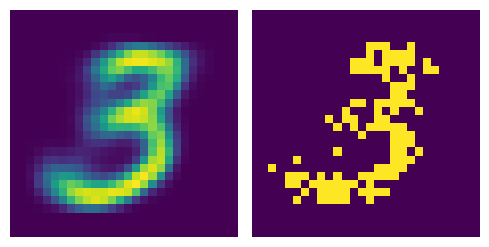

In [11]:
test_img = next(iter(MNIST_dataset))[0]
test_img = tf.reshape(test_img, shape=(1, 28, 28))
test.visualize_data_space(test_img)

# Latent space plot
A plot of the two dimnesions of the latent space (only the means) and their correspoding labels (numbers)

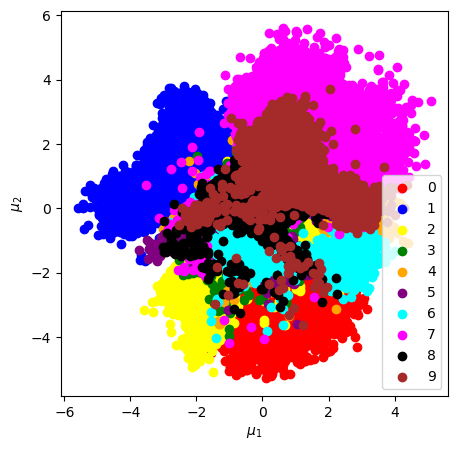

In [12]:
imgs = tf.concat([x for x in MNIST_dataset], axis=0) # get all the data back from the batches
test.visualize_latent_space(imgs, y_train)


## Interpolation plot
Linear interpolation of $\mu$ values of two different numbers shows how moving across the latent space generates different outputs.

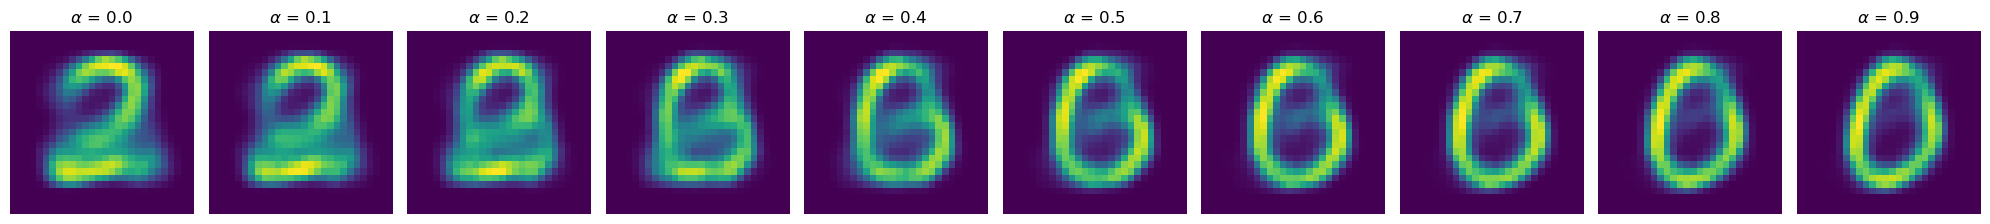

In [13]:
test.visualize_inter_class_interpolation(imgs, y_train)